# LunarLander-v3 Project using DQN and PPO

# 1. Libraries

In [1]:
# ====== Libraries  ======
import os
import random
import numpy as np

import gymnasium as gym

# Plots
import matplotlib.pyplot as plt
%matplotlib inline

# DQN 
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor


from collections import deque, namedtuple
import random
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

from IPython.display import Image, display


# 2. Create LunarLander-v3 environment

In [2]:
ENV_ID = "LunarLander-v3"
OUT_DIR = "runs_lunarlander"
os.makedirs(OUT_DIR, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)
print("Gymnasium:", gym.__version__)

Device: cpu
Gymnasium: 1.2.3


In [3]:
env = gym.make(ENV_ID)
obs, _ = env.reset(seed=42)
print("Env:", ENV_ID)
print("Obs space:", env.observation_space)
print("Action space:", env.action_space)
print("Obs shape:", obs.shape)
print("Example obs:", obs)
env.close()

Env: LunarLander-v3
Obs space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Action space: Discrete(4)
Obs shape: (8,)
Example obs: [ 0.00229702  1.4181306   0.2326471   0.3204666  -0.00265488 -0.05269805
  0.          0.        ]


# 4. CLASSES (ReplayBuffer, Network, DQNAgent)

In [4]:
Transition = namedtuple("Transition", ["s", "a", "r", "s2", "d"])

class ReplayBuffer:
    def __init__(self, capacity, device):
        self.buf = deque(maxlen=capacity)
        self.device = device

    def __len__(self):
        return len(self.buf)

    def add(self, s, a, r, s2, d):
        self.buf.append(Transition(s, a, r, s2, d))

    def sample(self, batch_size):
        batch = random.sample(self.buf, batch_size)
        s  = torch.tensor(np.vstack([t.s  for t in batch]), dtype=torch.float32, device=self.device)
        a  = torch.tensor(np.vstack([t.a  for t in batch]), dtype=torch.int64,   device=self.device)
        r  = torch.tensor(np.vstack([t.r  for t in batch]), dtype=torch.float32, device=self.device)
        s2 = torch.tensor(np.vstack([t.s2 for t in batch]), dtype=torch.float32, device=self.device)
        d  = torch.tensor(np.vstack([t.d  for t in batch]).astype(np.uint8), dtype=torch.float32, device=self.device)
        return s, a, r, s2, d

class Network(nn.Module):
    def __init__(self, state_size, action_size, hidden=256, seed=0):
        super().__init__()
        torch.manual_seed(seed)
        self.net = nn.Sequential(
            nn.Linear(state_size, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, action_size),
        )
    def forward(self, x):
        return self.net(x)

class DQNAgent:
    def __init__(
        self, state_size, action_size,
        lr, gamma, buffer_size, batch_size, tau,
        update_every, learning_starts, grad_clip, seed
    ):
        random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
        self.device = DEVICE
        self.action_size = action_size

        self.q = Network(state_size, action_size, seed=seed).to(self.device)
        self.q_tgt = Network(state_size, action_size, seed=seed+1).to(self.device)
        self.q_tgt.load_state_dict(self.q.state_dict())

        self.opt = optim.Adam(self.q.parameters(), lr=lr)
        self.buf = ReplayBuffer(buffer_size, self.device)

        self.gamma = gamma
        self.batch_size = batch_size
        self.tau = tau
        self.update_every = update_every
        self.learning_starts = learning_starts
        self.grad_clip = grad_clip

        self.total_steps = 0

    def act(self, state, eps):
        if random.random() < eps:
            return random.randrange(self.action_size)
        s = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        with torch.no_grad():
            qvals = self.q(s)
        return int(torch.argmax(qvals, dim=1).item())

    def store(self, s, a, r, s2, done):
        self.buf.add(s, a, r, s2, done)

    def soft_update(self):
        for p_tgt, p in zip(self.q_tgt.parameters(), self.q.parameters()):
            p_tgt.data.mul_(1.0 - self.tau)
            p_tgt.data.add_(self.tau * p.data)

    def train_step(self):
        if len(self.buf) < max(self.batch_size, self.learning_starts):
            return None

        s, a, r, s2, d = self.buf.sample(self.batch_size)

        with torch.no_grad():
            a2 = torch.argmax(self.q(s2), dim=1, keepdim=True)
            q2 = self.q_tgt(s2).gather(1, a2)
            y  = r + self.gamma * q2 * (1.0 - d)

        q_sa = self.q(s).gather(1, a)
        loss = F.smooth_l1_loss(q_sa, y)

        self.opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.q.parameters(), self.grad_clip)
        self.opt.step()

        self.soft_update()
        return float(loss.item())


# 5. UTILITIES (make_env, eval, gif)

In [5]:
def make_env(seed: int, render_mode=None):
    env = gym.make(ENV_ID, render_mode=render_mode)
    env.reset(seed=seed)
    env.action_space.seed(seed)
    return env

@torch.no_grad()
def evaluate_dqn(agent, n_episodes=20, seed=0, max_steps=1000):
    env = make_env(seed + 10_000)
    rets, lens = [], []
    for ep in range(n_episodes):
        s, _ = env.reset(seed=seed + 10_000 + ep)
        ep_ret, ep_len = 0.0, 0
        for _ in range(max_steps):
            a = agent.act(s, eps=0.0)
            s, r, terminated, truncated, _ = env.step(a)
            ep_ret += float(r); ep_len += 1
            if terminated or truncated:
                break
        rets.append(ep_ret); lens.append(ep_len)
    env.close()
    return float(np.mean(rets)), float(np.std(rets, ddof=1)), rets, lens

def moving_avg(x, w=100):
    x = np.asarray(x, float)
    if len(x) < w:
        return np.full_like(x, np.nan)
    c = np.convolve(x, np.ones(w)/w, mode="valid")
    return np.concatenate([np.full(w-1, np.nan), c])

def find_center_seed(agent, base_seed, tries, center_tol, max_steps):
    env = make_env(base_seed)
    for i in range(tries):
        s, _ = env.reset(seed=base_seed + i)
        for _ in range(max_steps):
            a = agent.act(s, eps=0.0)
            s, r, terminated, truncated, _ = env.step(a)
            if terminated or truncated:
                x = float(s[0])
                vx, vy = float(s[2]), float(s[3])
                left, right = float(s[6]), float(s[7])
                landed = (left > 0.5 or right > 0.5) and abs(vx) < 0.35 and abs(vy) < 0.35
                if landed and abs(x) < center_tol:
                    env.close()
                    return base_seed + i
                break
    env.close()
    return None

def save_gif(agent, seed_gif, gif_path, max_steps=1000, fps=30):
    import imageio
    env = make_env(seed_gif, render_mode="rgb_array")
    s, _ = env.reset(seed=seed_gif)
    frames, total_r = [], 0.0
    for _ in range(max_steps):
        frames.append(env.render())
        a = agent.act(s, eps=0.0)
        s, r, terminated, truncated, _ = env.step(a)
        total_r += float(r)
        if terminated or truncated:
            frames.append(env.render())
            break
    env.close()
    imageio.mimsave(gif_path, frames, fps=fps)
    return float(total_r)


# 6. SINGLE TRAIN ENTRYPOINT: run_dqn(cfg, seed)

In [ ]:
def run_dqn(cfg: dict, seed: int, run_name: str):
    cfg = dict(cfg)
    # defaults
    cfg.setdefault("gamma", 0.99)
    cfg.setdefault("grad_clip", 10.0)
    cfg.setdefault("eps_start", 1.0)
    cfg.setdefault("total_episodes", 5500)          # ↑ mais margem p/ performance
    cfg.setdefault("max_steps", 1000)
    cfg.setdefault("solved_avg100", 200.0)
    cfg.setdefault("lr_finetune", min(cfg["lr_finetune"], cfg["lr"]))
    cfg.setdefault("eval_episodes", 20)
    cfg.setdefault("extra_after_solved", 500)       # ↑ sobe “ceiling”
    cfg.setdefault("make_gif", False)
    cfg.setdefault("gif_tries", 1200)
    cfg.setdefault("center_tol", 0.12)

    # reproducibility
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

    env = make_env(seed)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = DQNAgent(
        state_size=state_size,
        action_size=action_size,
        lr=cfg["lr"],
        gamma=cfg["gamma"],
        buffer_size=int(cfg["buffer_size"]),
        batch_size=int(cfg["batch_size"]),
        tau=cfg["tau"],
        update_every=int(cfg["update_every"]),
        learning_starts=int(cfg["learning_starts"]),
        grad_clip=cfg["grad_clip"],
        seed=seed,
    )

    scores_100 = deque(maxlen=100)
    eps = cfg["eps_start"]
    solved_at, stop_at = None, None
    finetune_done = False

    ep_returns, ep_lengths, ep_eps, step_losses = [], [], [], []
    grad_updates = 0

    for ep in range(1, cfg["total_episodes"] + 1):
        s, _ = env.reset(seed=seed + ep)
        ep_ret, ep_len = 0.0, 0

        for _ in range(cfg["max_steps"]):
            a = agent.act(s, eps=eps)
            s2, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated

            agent.store(s, a, float(r), s2, done)

            agent.total_steps += 1
            if agent.total_steps % agent.update_every == 0:
                loss = agent.train_step()
                if loss is not None:
                    step_losses.append(loss)
                    grad_updates += 1

            s = s2
            ep_ret += float(r); ep_len += 1
            if done:
                break

        ep_returns.append(ep_ret)
        ep_lengths.append(ep_len)
        ep_eps.append(eps)

        scores_100.append(ep_ret)
        avg100 = float(np.mean(scores_100))

        eps = max(cfg["eps_min"], eps * cfg["eps_decay"])

        if ep % 50 == 0:
            last_loss = float(np.mean(step_losses[-200:])) if len(step_losses) else np.nan
            print(f"{run_name} | Ep {ep:4d} | avg100: {avg100:7.2f} | eps: {eps:6.3f} | loss~: {last_loss:6.3f}")

        if len(scores_100) == 100 and avg100 >= cfg["solved_avg100"] and stop_at is None:
            solved_at = ep
            stop_at = min(cfg["total_episodes"], ep + cfg["extra_after_solved"])
            if not finetune_done:
                for g in agent.opt.param_groups:
                    g["lr"] = cfg["lr_finetune"]
                finetune_done = True
            print(f"\n {run_name} solved at ep {ep} | avg100 {avg100:.2f} | continue until ep {stop_at} | finetune_lr {cfg['lr_finetune']}\n")

        if stop_at is not None and ep >= stop_at:
            break

    env.close()

    mean_eval, std_eval, _, _ = evaluate_dqn(agent, n_episodes=cfg["eval_episodes"], seed=seed, max_steps=cfg["max_steps"])

    model_path = os.path.join(OUT_DIR, f"{run_name}_seed{seed}.pth")
    torch.save(agent.q.state_dict(), model_path)

    curves_path = os.path.join(OUT_DIR, f"{run_name}_seed{seed}_curves.npz")
    np.savez(
        curves_path,
        returns=np.array(ep_returns, float),
        lengths=np.array(ep_lengths, int),
        eps=np.array(ep_eps, float),
        losses=np.array(step_losses, float),
        solved_at_episode=np.array([-1 if solved_at is None else solved_at], int),
        total_steps=np.array([agent.total_steps], int),
        grad_updates=np.array([grad_updates], int),
    )

    res = {
        "seed": seed,
        "cfg": cfg,
        "run_name": run_name,
        "solved_at_episode": solved_at,
        "train_episodes": len(ep_returns),
        "train_total_steps": agent.total_steps,
        "grad_updates": grad_updates,
        "eval_mean": mean_eval,
        "eval_std": std_eval,
        "model_path": model_path,
        "curves_path": curves_path,
    }

    if cfg["make_gif"]:
        good = find_center_seed(agent, base_seed=seed + 1000, tries=cfg["gif_tries"], center_tol=cfg["center_tol"], max_steps=cfg["max_steps"])
        if good is not None:
            gif_path = os.path.join(OUT_DIR, f"{run_name}_seed{seed}_best.gif")
            gif_ret = save_gif(agent, seed_gif=good, gif_path=gif_path, max_steps=cfg["max_steps"], fps=30)
            res["center_gif_path"] = gif_path
            res["center_gif_seed"] = int(good)
            res["center_gif_return"] = float(gif_ret)
            print("Saved GIF:", gif_path, "| return:", round(gif_ret, 2))

    return res


# 7. MONTE CARLO LOOP + select best (triagem)

In [7]:
def sample_dqn_cfg(rng: random.Random):
    lr = rng.choice([2e-4, 1e-4, 8e-5, 5e-5, 3e-5])
    lr_ft_choices = [x for x in [1e-4, 8e-5, 5e-5, 3e-5] if x <= lr]
    return {
        "lr": lr,
        "lr_finetune": rng.choice(lr_ft_choices),
        "tau": rng.choice([2e-3, 1e-3, 5e-4]),
        "batch_size": rng.choice([64, 128, 256]),
        "buffer_size": rng.choice([200_000, 500_000]),
        "learning_starts": 2000,
        "update_every": 4,
        "eps_decay": rng.choice([0.995, 0.997, 0.999]),
        "eps_min": rng.choice([0.01, 0.005]),
        "extra_after_solved": rng.choice([300, 500, 800]),  # ↑ performance ceiling
        "eval_episodes": 20,
        "make_gif": False,
    }


# 8. FINAL EVAL (3 seeds) + plots + gif do melhor

In [ ]:
def mc_tune_dqn(n_trials=15, tune_seed=42, train_seed=42):
    rng = random.Random(tune_seed)
    trials, best = [], None

    for t in range(1, n_trials + 1):
        cfg = sample_dqn_cfg(rng)
        run_name = f"dqn_trial{t:02d}"

        print(f"\n=== Trial {t}/{n_trials} | cfg: {cfg} ===")
        res = run_dqn(cfg, seed=train_seed, run_name=run_name)
        trials.append(res)

        if (best is None) or (res["eval_mean"] > best["eval_mean"]):
            best = res

        print(f"Trial {t} -> eval_mean: {res['eval_mean']:.2f} ± {res['eval_std']:.2f} | BEST: {best['eval_mean']:.2f}")

    return trials, best



=== Trial 1/8 | cfg: {'lr': 0.0002, 'lr_finetune': 0.0001, 'tau': 0.0005, 'batch_size': 128, 'buffer_size': 200000, 'learning_starts': 2000, 'update_every': 4, 'eps_decay': 0.995, 'eps_min': 0.01, 'extra_after_solved': 800, 'eval_episodes': 20, 'make_gif': False} ===
dqn_trial01 | Ep   50 | avg100: -188.45 | eps:  0.778 | loss~:  1.571
dqn_trial01 | Ep  100 | avg100: -150.42 | eps:  0.606 | loss~:  1.494
dqn_trial01 | Ep  150 | avg100: -104.53 | eps:  0.471 | loss~:  1.255
dqn_trial01 | Ep  200 | avg100:  -80.27 | eps:  0.367 | loss~:  1.305
dqn_trial01 | Ep  250 | avg100:  -42.14 | eps:  0.286 | loss~:  1.236
dqn_trial01 | Ep  300 | avg100:  -32.74 | eps:  0.222 | loss~:  0.947
dqn_trial01 | Ep  350 | avg100:  -51.33 | eps:  0.173 | loss~:  0.735
dqn_trial01 | Ep  400 | avg100:  -38.43 | eps:  0.135 | loss~:  0.608
dqn_trial01 | Ep  450 | avg100:   32.48 | eps:  0.105 | loss~:  0.424
dqn_trial01 | Ep  500 | avg100:  118.98 | eps:  0.082 | loss~:  0.295
dqn_trial01 | Ep  550 | avg100:

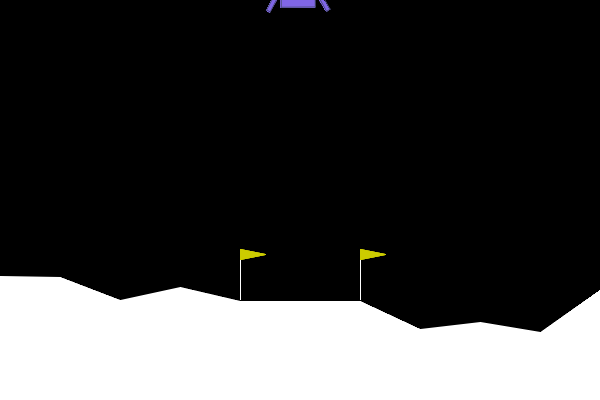

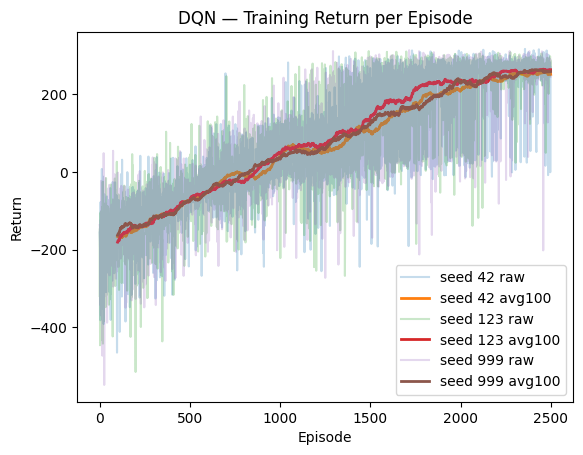

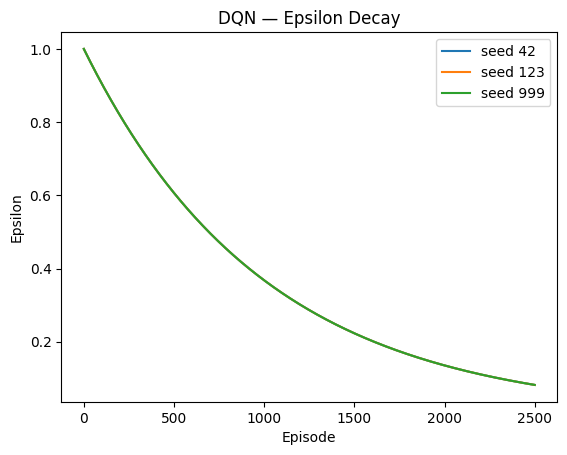

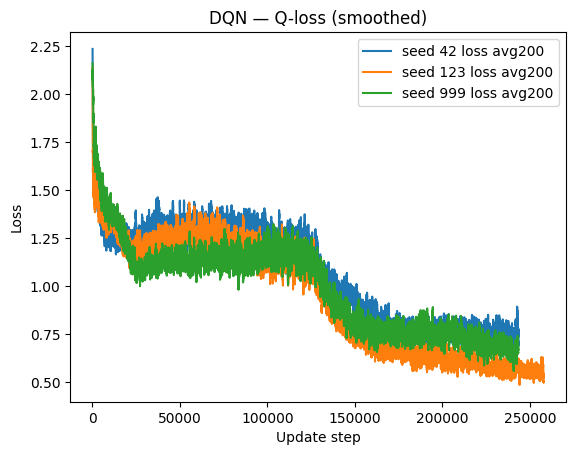

In [ ]:
# 1) Tune
dqn_trials, best_dqn = mc_tune_dqn(n_trials=15, tune_seed=42, train_seed=42)
print("\nBEST CFG:", best_dqn["cfg"])

# 2) Final 3 seeds (fair comparison)
FINAL_SEEDS = [42, 123, 999]
final_cfg = dict(best_dqn["cfg"])
final_cfg["eval_episodes"] = 20
final_cfg["make_gif"] = False  # gifs só no melhor final

dqn_final = []
for s in FINAL_SEEDS:
    print("\n=== FINAL seed", s, "===")
    dqn_final.append(run_dqn(final_cfg, seed=s, run_name="dqn_final"))

means = [r["eval_mean"] for r in dqn_final]
print("\nFINAL mean across seeds:", float(np.mean(means)), "| std:", float(np.std(means, ddof=1)))

# 3) Pick best FINAL seed and generate GIF (1 run extra, só para gif)
best_seed = max(dqn_final, key=lambda x: x["eval_mean"])
gif_cfg = dict(final_cfg)
gif_cfg["make_gif"] = True
gif_run = run_dqn(gif_cfg, seed=best_seed["seed"], run_name="dqn_best_gif")

from IPython.display import Image, display
display(Image(filename=gif_run["center_gif_path"]))

# 4) Plots: returns + avg100, epsilon, loss (por seed)
def load_curves(path):
    d = np.load(path, allow_pickle=True)
    return {k: d[k] for k in d.files}

plt.figure()
for r in dqn_final:
    c = load_curves(r["curves_path"])
    y = c["returns"]
    plt.plot(y, alpha=0.25, label=f"seed {r['seed']} raw")
    plt.plot(moving_avg(y, 100), linewidth=2, label=f"seed {r['seed']} avg100")
plt.title("DQN — Training Return per Episode")
plt.xlabel("Episode"); plt.ylabel("Return"); plt.legend(); plt.show()

plt.figure()
for r in dqn_final:
    c = load_curves(r["curves_path"])
    plt.plot(c["eps"], label=f"seed {r['seed']}")
plt.title("DQN — Epsilon Decay")
plt.xlabel("Episode"); plt.ylabel("Epsilon"); plt.legend(); plt.show()

plt.figure()
for r in dqn_final:
    c = load_curves(r["curves_path"])
    if len(c["losses"]) > 0:
        plt.plot(moving_avg(c["losses"], 200), label=f"seed {r['seed']} loss avg200")
plt.title("DQN — Q-loss (smoothed)")
plt.xlabel("Update step"); plt.ylabel("Loss"); plt.legend(); plt.show()



# 9. DIFFERENCIATOR: stress-test wind (evaluation only)

In [ ]:
wind_kwargs = dict(enable_wind=True, wind_power=10.0, turbulence_power=1.0)

# Evaluate FINAL best seed agent under wind by reloading weights into a fresh agent
# (keeps the notebook minimal and reproducible)
def eval_saved_model_under_wind(model_path, seed=0, n_episodes=20, max_steps=1000):
    env = make_env(seed, **wind_kwargs)
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n
    env.close()

    agent = DQNAgent(obs_dim, act_dim, seed=seed)
    agent.q.load_state_dict(torch.load(model_path, map_location=device))
    agent.q.eval()
    agent.q_tgt.load_state_dict(agent.q.state_dict())

    mean_w, std_w, _, _ = evaluate_dqn(agent, n_episodes=n_episodes, seed=seed, max_steps=max_steps, **wind_kwargs)
    return mean_w, std_w

best_seed = max(dqn_final, key=lambda x: x["eval_mean"])
mw, sw = eval_saved_model_under_wind(best_seed["model_path"], seed=best_seed["seed"], n_episodes=20)
print(f"Wind stress-test (20 eps) mean±std: {mw:.2f} ± {sw:.2f} | wind_power=10 | turbulence=1.0")